In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

## 1.Diffusion Model (based on DDPM sampling)

Implements DDPM (Denoising Diffusion Probabilistic Model) with only the essentials from the timegrad codebase

constants:

betas: Noise Variance Schedule. This creates a 1D tensor of T (where T=num_steps) values, typically ranging from a small value (0.0001) to a larger value (0.02). βt dictates how much variance (noise) is added at each step t in the forward process. A linear schedule is a common, simple choice.

alphas:
Signal Retention Schedule. This is the complement of beta
tells us how much of the original signal is retained after the noise addition at step t. Since beta
is small, αt is close to 1.0.

self.register_buffer(...) PyTorch Registration. This ensures these calculated constants are saved as part of the model's state (when saving/loading the model) but are not considered trainable parameters.



In [2]:
class DiffusionModel(nn.Module):
    def __init__(self, denoiser, data_dim, num_steps=50):
        super().__init__()
        self.denoiser = denoiser
        self.data_dim = data_dim
        self.num_steps = num_steps
        
        # Create noise schedule (linear)
        betas = torch.linspace(0.0001, 0.02, num_steps)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        alphas_cumprod_prev = torch.cat([torch.tensor([1.0]), alphas_cumprod[:-1]])
        
        # Register as buffers
        self.register_buffer('betas', betas)
        self.register_buffer('alphas', alphas)
        self.register_buffer('alphas_cumprod', alphas_cumprod)
        self.register_buffer('alphas_cumprod_prev', alphas_cumprod_prev)
        self.register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1 - alphas_cumprod))
        
        # precomputing posterior coeffs 
        posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        self.register_buffer('posterior_variance', posterior_variance)
        
        # coeffs for posterior mean 
        self.register_buffer(
            'posterior_mean_coef1',
            betas * torch.sqrt(alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        )
        self.register_buffer(
            'posterior_mean_coef2',
            (1.0 - alphas_cumprod_prev) * torch.sqrt(alphas) / (1.0 - alphas_cumprod)
        )
    
    def forward_process(self, x0, t, noise=None):
        """Add noise to clean data x0 at timestep t
        
        Args:
            x0: Clean data of shape (batch_size, 1, data_dim)
            t: Timestep tensor of shape (batch_size,)
            noise: Optional noise tensor
            
        Returns:
            Noisy data of shape (batch_size, 1, data_dim)
        """
        if noise is None:
            noise = torch.randn_like(x0)
        
        sqrt_alpha_t = self.sqrt_alphas_cumprod[t].view(-1, 1, 1)
        sqrt_one_minus_alpha_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1)
        
        return sqrt_alpha_t * x0 + sqrt_one_minus_alpha_t * noise
    
    def predict_start_from_noise(self, x_t, t, noise):
        """Predict x_0 from x_t and predicted noise (from DDPM paper)"""
        sqrt_alpha_t = self.sqrt_alphas_cumprod[t].view(-1, 1, 1)
        sqrt_one_minus_alpha_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1)
        return (x_t - sqrt_one_minus_alpha_t * noise) / sqrt_alpha_t
    
    def q_posterior_mean(self, x_start, x_t, t):
        """Compute posterior mean using precomputed coefficients"""
        coef1 = self.posterior_mean_coef1[t].view(-1, 1, 1)
        coef2 = self.posterior_mean_coef2[t].view(-1, 1, 1)
        return coef1 * x_start + coef2 * x_t
    
    @torch.no_grad()
    def sample(self, cond):
        """DDPM sampling - Algorithm 2 from paper
        
        Args:
            cond: Context tensor of shape (batch_size, context_dim)
            
        Returns:
            Sampled data of shape (batch_size, 1, data_dim)
        """
        batch_size = cond.shape[0]
        device = cond.device
        
        # Start from pure noise - shape (batch_size, 1, data_dim)
        x = torch.randn(batch_size, 1, self.data_dim, device=device)
        
        for t in reversed(range(self.num_steps)):
            t_tensor = torch.full((batch_size,), t, device=device, dtype=torch.long)
            
            # predicting noise
            pred_noise = self.denoiser(x, t_tensor, cond)
            
            # predicting x_0
            x_0_pred = self.predict_start_from_noise(x, t_tensor, pred_noise)
            
            if t > 0:
                # computing posterior mean
                posterior_mean = self.q_posterior_mean(x_0_pred, x, t_tensor)
                
                # noise with posterior variance
                noise = torch.randn_like(x)
                posterior_var = self.posterior_variance[t]
                x = posterior_mean + torch.sqrt(posterior_var) * noise
            else:
                # Final step: no noise
                x = x_0_pred
        
        return x
    
    def training_loss(self, x0, context):
        """MSE loss between predicted and true noise
        
        Args:
            x0: Target data of shape (batch_size, data_dim)
            context: Context tensor of shape (batch_size, context_dim)
            
        Returns:
            Scalar loss value
        """
        batch_size = x0.shape[0]
        device = x0.device
        
        # Reshape x0 to (batch_size, 1, data_dim) for consistency
        x0 = x0.view(batch_size, 1, -1)
        
        # Random timesteps 
        t = torch.randint(0, self.num_steps, (batch_size,), device=device)
        
        # Add noise
        noise = torch.randn_like(x0)
        x_noisy = self.forward_process(x0, t, noise)
        
        # Predict noise
        pred_noise = self.denoiser(x_noisy, t, context)
        
        return F.mse_loss(pred_noise, noise)

## 2. Simple Denoiser Network

MLP that takes noisy data, timestep, and context to predict the noise that was added.

In [3]:
class SimpleDenoiser(nn.Module):
    def __init__(self, data_dim, context_dim, hidden_dim=128):
        super().__init__()
        self.data_dim = data_dim
        
        self.time_embed = nn.Sequential(
            nn.Linear(1, 8),
            nn.SiLU(),
        )
        
        # balance context with time embedding
        self.context_embed = nn.Sequential(
            nn.Linear(context_dim, 32),
            nn.SiLU(),
        )
        
        self.net = nn.Sequential(
            nn.Linear(data_dim + 32 + 8, hidden_dim),  
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, data_dim)
        )
    
    def forward(self, x, t, cond):
        batch_size = x.shape[0]
        x_flat = x.view(batch_size, -1)
        t_emb = self.time_embed(t.float().unsqueeze(-1))
        cond_emb = self.context_embed(cond) 
        
        h = torch.cat([x_flat, cond_emb, t_emb], dim=-1)
        noise = self.net(h)
        return noise.view(batch_size, 1, self.data_dim)

In [ ]:

class LinearRNN(nn.Module):
    """ linear RNN: h_t = W @ h_{t-1} (no input, no bias)"""
    def __init__(self, hidden_size):
        super().__init__()
        
        self.hidden_size = hidden_size
        
        # set to identity matrix
        self.W = nn.Parameter(torch.eye(hidden_size))
        
    def forward(self, h):
        """ h_t = h_{t-1} @ W^T
        Args:
            h: Current hidden state (batch_size, hidden_size)
        Returns:
            h_next: Next hidden state (batch_size, hidden_size)
        """
        return h @ self.W.t()  


## 3. TimeGrad Model

Combines LSTM encoder (for past context) with diffusion model (for probabilistic forecasting). Uses autoregressive generation matching the training procedure.

In [5]:
class TimeGrad(nn.Module):
    def __init__(self, data_dim, num_diffusion_steps=100):
        super().__init__()
        self.data_dim = data_dim
        
        # Linear RNN: h_t = W_h @ h_{t-1} + b
        self.rnn = LinearRNN(data_dim)
        
        # Denoiser network
        self.denoiser = SimpleDenoiser(data_dim, context_dim=data_dim, hidden_dim=128)
        
        # Diffusion process
        self.diffusion = DiffusionModel(self.denoiser, data_dim, num_diffusion_steps)
    
    def forward(self, trajectories, h0):
        batch_size, T, _ = trajectories.shape
        
        total_loss = 0.0
        h = h0
        
        for t in range(1, T-2):  # Leave room for multi-step
            h = self.rnn(h)  # Update hidden state
            
            # Single-step loss (as before)
            x_t = trajectories[:, t, :]
            loss_1step = self.diffusion.training_loss(x_t, context=h)
            
            # Multi-step loss (NEW!)
            # Predict x_{t+1} and x_{t+2} from SAME h
            h_next = self.rnn(h)
            x_t1 = trajectories[:, t+1, :]
            loss_2step = self.diffusion.training_loss(x_t1, context=h_next)
            
            h_next2 = self.rnn(h_next)
            x_t2 = trajectories[:, t+2, :]
            loss_3step = self.diffusion.training_loss(x_t2, context=h_next2)
            
            # Combined loss
            total_loss += loss_1step + 0.5*loss_2step + 0.25*loss_3step
        
        return total_loss / (T - 3)



    def forecast(self, num_steps, h0, num_samples=1):
        """Generate forecasts autoregressively with running hidden state

        Args:
            num_steps: How many future steps to predict
            h0: Initial hidden state (batch_size, hidden_dim)
            num_samples: Number of sample paths per batch item
        """
        self.eval()
        with torch.no_grad():
            batch_size = h0.shape[0]

            if num_samples == 1:
                forecasts = []
                h = h0  # the running hidden state

                for step in range(num_steps):
                    # Get context and generate sample
                    context = h
                    next_step = self.diffusion.sample(cond=context)
                    forecasts.append(next_step.squeeze(1))

                    # Update hidden state for next timestep
                    h = self.rnn(h)

                return torch.stack(forecasts, dim=1)

            else:
                # Repeat for multiple samples
                h0_repeated = h0.repeat_interleave(num_samples, dim=0)
                forecasts = []
                h = h0_repeated  # Running hidden state

                for step in range(num_steps):
                    # Get context and generate sample
                    context = h
                    next_step = self.diffusion.sample(cond=context)
                    forecasts.append(next_step.squeeze(1))

                    # Update hidden state for next timestep
                    h = self.rnn(h)

                samples = torch.stack(forecasts, dim=1)
                samples = samples.view(batch_size, num_samples, num_steps, self.data_dim)
                return samples

## 4.2D OU Data Generation

Generates 2d Ornstein-Uhlenbeck processes 

In [6]:
def generate_ou_data(theta, mu, sigma, x0, num_series=500, seq_len=100, dt=1):
    """Generate simple OU trajectories per supervisor's instructions"""
    data_dim = len(mu)
    all_series = []
    
    for _ in range(num_series):
        x = torch.zeros(seq_len, data_dim)
        x[0] = x0.clone()
        
        for t in range(1, seq_len):
            drift = -theta @ (x[t-1] - mu) * dt
            noise = sigma @ torch.randn(data_dim) * torch.sqrt(torch.tensor(dt))
            x[t] = x[t-1] + drift + noise
        
        all_series.append(x)
    
    return torch.stack(all_series)


In [7]:
# OU parameters (following supervisor's instructions)
theta_fixed = torch.tensor([[2.0, 0.0], [0.0, 1.5]], dtype=torch.float32)
mu = torch.tensor([0.0, 0.0], dtype=torch.float32)
sigma = torch.tensor([[0.3, 0.0], [0.0, 0.2]], dtype=torch.float32)
x0 = torch.tensor([1.5, 1.0], dtype=torch.float32)
dt = 0.1  # Single consistent dt value

# what trainstion matrix W should loosely be
W_theory_continuous = torch.eye(2) - theta_fixed * dt
print(f"Theoretical W = I - Θ×dt (dt={dt}):")
print(W_theory_continuous)

# eigenvalues must have magnitude < 1)
eigs_discrete = torch.linalg.eigvals(W_theory_continuous)
print(f"\nEigenvalues of W: {eigs_discrete}")
print(f"Magnitudes: {torch.abs(eigs_discrete)}")
assert torch.all(torch.abs(eigs_discrete) < 1), "Discrete-time system unstable!"
print("✓ Discrete-time system is stable")


Theoretical W = I - Θ×dt (dt=0.1):
tensor([[0.8000, 0.0000],
        [0.0000, 0.8500]])

Eigenvalues of W: tensor([0.8000+0.j, 0.8500+0.j])
Magnitudes: tensor([0.8000, 0.8500])
✓ Discrete-time system is stable


## 5. Training Loop

Simple training with autoregressive loss matching the inference procedure.

In [8]:
print("Generating OU data for training...")
data = generate_ou_data(
    theta=theta_fixed,
    mu=mu,
    sigma=sigma,
    x0=x0,
    num_series=500,      
    seq_len=25,            
    dt=dt  # Use the dt from previous cell (0.1)
)

Generating OU data for training...


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

model = TimeGrad(
    data_dim=2,
    num_diffusion_steps=50,
).to(device)


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

Using device: cpu


Training TimeGrad with W tracking...
Epoch 0/10000, Loss: 1.9692, W Error: 0.2452
Epoch 50/10000, Loss: 0.5094, W Error: 0.2776
Epoch 100/10000, Loss: 0.4693, W Error: 0.2591
Epoch 150/10000, Loss: 0.4615, W Error: 0.2467
Epoch 200/10000, Loss: 0.4475, W Error: 0.2357
Epoch 250/10000, Loss: 0.4453, W Error: 0.2268
Epoch 300/10000, Loss: 0.4401, W Error: 0.2213
Epoch 350/10000, Loss: 0.4440, W Error: 0.2175
Epoch 400/10000, Loss: 0.4396, W Error: 0.2143
Epoch 450/10000, Loss: 0.4456, W Error: 0.2119
Epoch 500/10000, Loss: 0.4355, W Error: 0.2093
Epoch 550/10000, Loss: 0.4386, W Error: 0.2073
Epoch 600/10000, Loss: 0.4424, W Error: 0.2051
Epoch 650/10000, Loss: 0.4267, W Error: 0.2051
Epoch 700/10000, Loss: 0.4417, W Error: 0.2036
Epoch 750/10000, Loss: 0.4393, W Error: 0.2038
Epoch 800/10000, Loss: 0.4382, W Error: 0.2034
Epoch 850/10000, Loss: 0.4457, W Error: 0.2021
Epoch 900/10000, Loss: 0.4347, W Error: 0.2023
Epoch 950/10000, Loss: 0.4367, W Error: 0.2020
Epoch 1000/10000, Loss: 0.

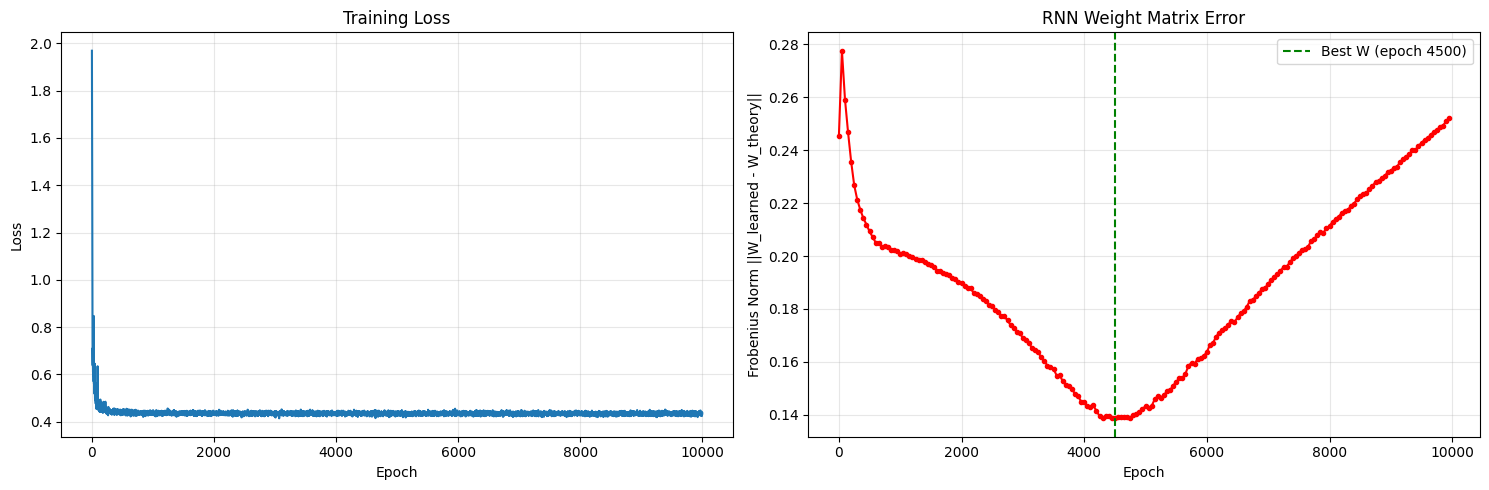


RESULTS AT BEST EPOCH (4500):

Best W:
tensor([[ 0.8223, -0.0496],
        [ 0.1033,  0.9249]])

Theoretical W:
tensor([[0.8000, 0.0000],
        [0.0000, 0.8500]])

Difference:
tensor([[ 0.0223, -0.0496],
        [ 0.1033,  0.0749]])

Best Frobenius error: 0.138661


In [ ]:

from torch.utils.data import DataLoader

print("Training TimeGrad with W tracking...")
losses = []
W_errors = []
checkpoint_epochs = []

num_epochs = 10000
batch_size = 64
loader = DataLoader(data, batch_size=batch_size, shuffle=True)

# Track best W for early stopping
best_W_error = float('inf')
best_W = None
best_epoch = 0

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch in loader:
        batch = batch.to(device)
        h0_batch = x0.repeat(batch.shape[0], 1).to(device)

        optimizer.zero_grad()
        loss = model(batch, h0_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(loader)
    losses.append(avg_loss)

    # Track W error at checkpoints
    if epoch % 50 == 0:
        W_learned = model.rnn.W.detach().cpu()
        W_error = torch.norm(W_learned - W_theory_continuous, p='fro').item()
        W_errors.append(W_error)
        checkpoint_epochs.append(epoch)
        
        # Track best W
        if W_error < best_W_error:
            best_W_error = W_error
            best_W = W_learned.clone()
            best_epoch = epoch
        
        print(f"Epoch {epoch}/{num_epochs}, Loss: {avg_loss:.4f}, W Error: {W_error:.4f}")

print(f"\nTraining complete. Final loss: {losses[-1]:.4f}")
print(f"Best W error: {best_W_error:.6f} at epoch {best_epoch}")

# Plot both loss and W error
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(losses, linewidth=1.5)
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True, alpha=0.3)

axes[1].plot(checkpoint_epochs, W_errors, linewidth=1.5, color='red', marker='o', markersize=3)
axes[1].axvline(x=best_epoch, color='green', linestyle='--', label=f'Best W (epoch {best_epoch})')
axes[1].set_title('RNN Weight Matrix Error')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Frobenius Norm ||W_learned - W_theory||')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show results at best epoch
print("\n" + "="*50)
print(f"RESULTS AT BEST EPOCH ({best_epoch}):")
print("="*50)
print(f"\nBest W:\n{best_W}")
print(f"\nTheoretical W:\n{W_theory_continuous}")
print(f"\nDifference:\n{best_W - W_theory_continuous}")
print(f"\nBest Frobenius error: {best_W_error:.6f}")

In [ ]:

difference = W_learned - W_theory_continuous
frobenius_norm = torch.norm(difference, p='fro').item()

print(f"\nDifference matrix:")
print(difference)
print(f"\nFrobenius norm of difference: {frobenius_norm:.6f}")

# elementwise relative error
relative_error = torch.abs(difference / W_theory_continuous) * 100
print(f"\nRelative error (%):")
print(relative_error)


Difference matrix:
tensor([[-0.1022, -0.0126],
        [ 0.2249, -0.0548]])

Frobenius norm of difference: 0.253322

Relative error (%):
tensor([[12.7801,     inf],
        [    inf,  6.4427]])
